In [1]:
from pathlib import Path
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

ROOT = Path("..")
DATA_PROCESSED = ROOT / "data" / "processed" / "db1"
MODELS_DIR     = ROOT / "models" / "db1"
REPORTS_DIR    = ROOT / "reports" / "db1"
for p in [MODELS_DIR, REPORTS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [2]:
# --- Load as before ---
train_npz = DATA_PROCESSED / "dl_train_db1_raw.npz"
val_npz   = DATA_PROCESSED / "dl_val_db1_raw.npz"
test_npz  = DATA_PROCESSED / "dl_test_db1_raw.npz"

ztr = np.load(train_npz, allow_pickle=True)
zva = np.load(val_npz,   allow_pickle=True)
zte = np.load(test_npz,  allow_pickle=True)

Xtr, ytr = ztr["X"], ztr["y"]
Xva, yva = zva["X"], zva["y"]
Xte, yte = zte["X"], zte["y"]
idx_to_label = ztr["idx_to_label"]
n_classes = len(idx_to_label)
print("Train:", Xtr.shape, "Val:", Xva.shape, "Test:", Xte.shape, "classes:", n_classes)

# # --- Subsample for CPU demo ---
# # choose a fraction or a fixed number per split
# N_train, N_val, N_test = 2000, 500, 500   # adjust as needed

# rng = np.random.default_rng(seed=0)  # reproducible
# train_idx = rng.choice(len(Xtr), size=min(N_train, len(Xtr)), replace=False)
# val_idx   = rng.choice(len(Xva), size=min(N_val, len(Xva)), replace=False)
# test_idx  = rng.choice(len(Xte), size=min(N_test, len(Xte)), replace=False)

# Xtr, ytr = Xtr[train_idx], ytr[train_idx]
# Xva, yva = Xva[val_idx], yva[val_idx]
# Xte, yte = Xte[test_idx], yte[test_idx]

def stratified_cap(X, y, per_class=200, seed=0):
    rng = np.random.default_rng(seed)
    keep_idx = []
    for c in np.unique(y):
        idx = np.where(y == c)[0]
        if len(idx) == 0: 
            continue
        take = min(per_class, len(idx))
        keep_idx.extend(rng.choice(idx, size=take, replace=False))
    keep_idx = np.array(keep_idx)
    return X[keep_idx], y[keep_idx]

# after loading NPZs:
Xtr, ytr = stratified_cap(Xtr, ytr, per_class=400, seed=0)
Xva, yva = stratified_cap(Xva, yva, per_class=100, seed=1)
Xte, yte = stratified_cap(Xte, yte, per_class=100, seed=2)

# sanity: show class counts
for name, yv in [("train", ytr), ("val", yva), ("test", yte)]:
    vals, cnts = np.unique(yv, return_counts=True)
    print(name, "classes:", len(vals), "min/max per class:", cnts.min(), cnts.max())
    

print("Train:", Xtr.shape, "Val:", Xva.shape, "Test:", Xte.shape, "classes:", n_classes)

Train: (312643, 50, 10) Val: (93436, 50, 10) Test: (93476, 50, 10) classes: 23
train classes: 23 min/max per class: 400 400
val classes: 23 min/max per class: 100 100
test classes: 23 min/max per class: 100 100
Train: (9200, 50, 10) Val: (2300, 50, 10) Test: (2300, 50, 10) classes: 23


In [3]:
class EMGSeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.astype(np.float32)    # (N, T, C)
        self.y = y.astype(np.int64)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i):
        return torch.from_numpy(self.X[i]), torch.tensor(self.y[i], dtype=torch.long)

BATCH_SIZE = 128  # shrink if memory bound
train_ds = EMGSeqDataset(Xtr, ytr)
val_ds   = EMGSeqDataset(Xva, yva)
test_ds  = EMGSeqDataset(Xte, yte)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

xb, yb = next(iter(train_loader))
xb.shape  # expect (B, T, C)

torch.Size([128, 50, 10])

In [4]:
class LSTMClassifier(nn.Module):
    def __init__(self, n_features, n_classes, hidden=128, layers=2, bidir=True, dropout=0.2):
        super().__init__()
        self.bidir = bidir
        self.lstm = nn.LSTM(
            input_size=n_features, hidden_size=hidden, num_layers=layers,
            batch_first=True, dropout=(dropout if layers > 1 else 0.0), bidirectional=bidir
        )
        out_dim = hidden * (2 if bidir else 1)
        self.head = nn.Sequential(
            nn.LayerNorm(out_dim),
            nn.Linear(out_dim, out_dim), nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(out_dim, n_classes),
        )

    def forward(self, x):  # x: (B, T, C)
        h, _ = self.lstm(x)        # (B, T, H*dirs)
        # temporal aggregation — mean pooling is robust on short sequences
        h_mean = h.mean(dim=1)     # (B, H*dirs)
        return self.head(h_mean)

n_features = Xtr.shape[2]
model = LSTMClassifier(n_features=n_features, n_classes=n_classes, hidden=128, layers=2, bidir=True, dropout=0.3).to(DEVICE)
sum(p.numel() for p in model.parameters())  # param count

610839

In [5]:
# Class weights from training distribution
vals, cnts = np.unique(ytr, return_counts=True)
class_count = np.zeros(n_classes, dtype=np.float32)
class_count[vals] = cnts
weights = 1.0 / (class_count + 1e-6)
weights = torch.tensor(weights / weights.mean(), dtype=torch.float32, device=DEVICE)

criterion = nn.CrossEntropyLoss(weight=weights)  # or nn.CrossEntropyLoss() without weights
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)

def run_epoch(model, loader, optimizer=None):
    train_mode = optimizer is not None
    model.train(train_mode)
    total_loss, y_true, y_pred = 0.0, [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        loss = criterion(logits, yb)

        if train_mode:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * xb.size(0)
        y_true.append(yb.detach().cpu().numpy())
        y_pred.append(logits.argmax(dim=1).detach().cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")
    return total_loss / len(loader.dataset), acc, f1

In [6]:
EPOCHS = 25
PATIENCE = 5
best_val_f1, best_state = -1.0, None
no_improve = 0
hist = []

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, tr_f1 = run_epoch(model, train_loader, optimizer)
    va_loss, va_acc, va_f1 = run_epoch(model, val_loader,   optimizer=None)
    hist.append((epoch, tr_loss, tr_acc, tr_f1, va_loss, va_acc, va_f1))
    print(f"Epoch {epoch:02d} | train: loss {tr_loss:.4f} acc {tr_acc:.3f} f1 {tr_f1:.3f} | "
          f"val: loss {va_loss:.4f} acc {va_acc:.3f} f1 {va_f1:.3f}")

    if va_f1 > best_val_f1:
        best_val_f1 = va_f1
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print("Early stopping.")
            break

if best_state is not None:
    model.load_state_dict(best_state)

Epoch 01 | train: loss 2.8805 acc 0.141 f1 0.123 | val: loss 2.8116 acc 0.158 f1 0.133
Epoch 02 | train: loss 2.7398 acc 0.181 f1 0.165 | val: loss 2.7965 acc 0.166 f1 0.141
Epoch 03 | train: loss 2.6801 acc 0.202 f1 0.186 | val: loss 2.7748 acc 0.190 f1 0.159
Epoch 04 | train: loss 2.6267 acc 0.209 f1 0.196 | val: loss 2.7997 acc 0.182 f1 0.160
Epoch 05 | train: loss 2.5698 acc 0.228 f1 0.216 | val: loss 2.7714 acc 0.182 f1 0.156
Epoch 06 | train: loss 2.5156 acc 0.244 f1 0.233 | val: loss 2.7756 acc 0.178 f1 0.164
Epoch 07 | train: loss 2.4777 acc 0.259 f1 0.249 | val: loss 2.7956 acc 0.183 f1 0.161
Epoch 08 | train: loss 2.4224 acc 0.269 f1 0.259 | val: loss 2.8542 acc 0.184 f1 0.168
Epoch 09 | train: loss 2.3741 acc 0.279 f1 0.269 | val: loss 2.8502 acc 0.187 f1 0.164
Epoch 10 | train: loss 2.3214 acc 0.295 f1 0.287 | val: loss 2.8626 acc 0.191 f1 0.175
Epoch 11 | train: loss 2.2643 acc 0.313 f1 0.305 | val: loss 2.9832 acc 0.179 f1 0.162
Epoch 12 | train: loss 2.2011 acc 0.331 f1 

In [7]:
te_loss, te_acc, te_f1 = run_epoch(model, test_loader, optimizer=None)
print(f"Test — loss {te_loss:.4f}  acc {te_acc:.3f}  macro-F1 {te_f1:.3f}")

# Full report
y_true_all, y_pred_all = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb.to(DEVICE)).cpu().numpy()
        y_pred_all.append(np.argmax(logits, axis=1))
        y_true_all.append(yb.numpy())
y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

print(classification_report(y_true_all, y_pred_all, zero_division=0))

Test — loss 2.9753  acc 0.159  macro-F1 0.148
              precision    recall  f1-score   support

           0       0.03      0.02      0.02       100
           1       0.19      0.31      0.23       100
           2       0.08      0.04      0.05       100
           3       0.21      0.14      0.17       100
           4       0.27      0.15      0.19       100
           5       0.20      0.05      0.08       100
           6       0.16      0.18      0.17       100
           7       0.06      0.08      0.07       100
           8       0.04      0.02      0.03       100
           9       0.06      0.04      0.05       100
          10       0.08      0.05      0.06       100
          11       0.06      0.08      0.07       100
          12       0.16      0.12      0.14       100
          13       0.23      0.11      0.15       100
          14       0.19      0.28      0.22       100
          15       0.10      0.07      0.08       100
          16       0.07      0.13  

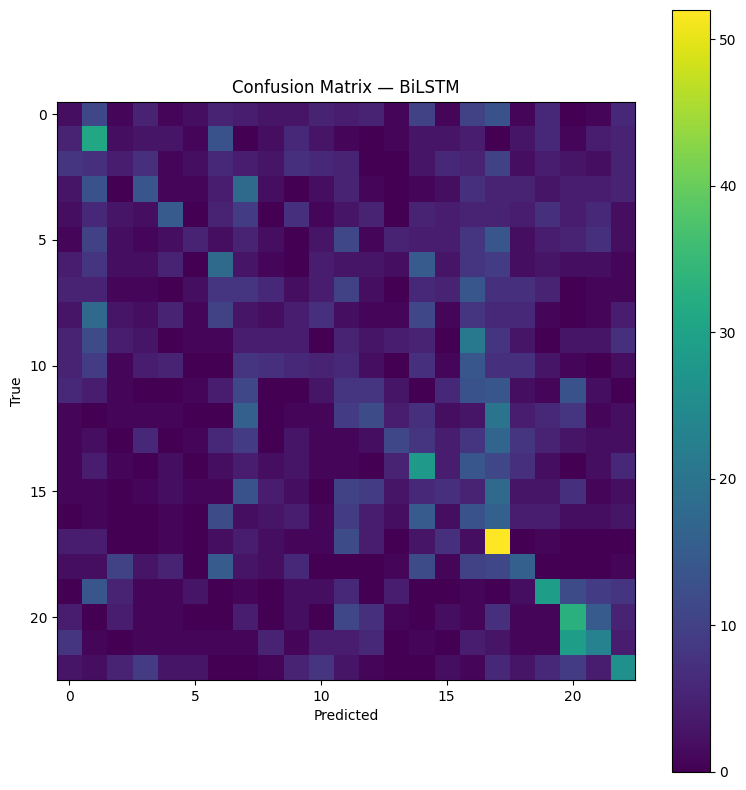

Saved: ../reports/db1/cm_lstm.png


In [8]:
cm = confusion_matrix(y_true_all, y_pred_all)

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("Confusion Matrix — BiLSTM")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.colorbar(im, ax=ax)
plt.tight_layout()

fig_path = REPORTS_DIR / "cm_lstm.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved:", fig_path)

In [9]:
ckpt_path = MODELS_DIR / "lstm_db1.pt"
meta_path = MODELS_DIR / "lstm_db1_meta.npz"

torch.save(model.state_dict(), ckpt_path)
np.savez_compressed(meta_path, n_features=n_features, n_classes=n_classes)

print("Saved model to:", ckpt_path)
print("Saved meta   to:", meta_path)

Saved model to: ../models/db1/lstm_db1.pt
Saved meta   to: ../models/db1/lstm_db1_meta.npz
